# 데이터셋 분할

## 실습 개요

데이터셋 분할

1) 실습 목적
- 이번 실습에서는 다양한 데이터셋 분할 방법을 탐색하고 이를 LightGBM에 적용해 봅니다.

2) 수강 목표
- 다양한 데이터 분할을 데이터에 적용할 수 있습니다.
- 분할된 데이터를 활용해 LightGBM을 학습할 수 있습니다.

### 실습 목차

* **1. 실습 데이터 준비**
  * 데이터 불러오기 및 전처리
* **2. 데이터 분할**
  * Holdout
  * K-Fold
  * Stratified K-Fold
  * Group K-Fold
  * Time-Series Split

### 데이터셋 개요
* 데이터셋: Yahoo Finance OHLCV 데이터셋이란? (Open High Close Low Volume)
* 데이터셋 개요 : **Yahoo Finance는 주식, 환율과 같은 금융 정보를 제공하는 플랫폼입니다.** 주식과 관련된 정보 및 시각화 정보를 웹사이트를 통해서 제공 (NASDAQ, KOSPI, NIKKEI 등) 됩니다. 데이터는 무료로 사용할 수 있으며, API를 제공하여 손쉽게 데이터를 수집 가능합니다. 또한, Yahoo Finance 정보를 랩핑한 yfinance 패키지를 이용해 파이썬에서도 사용 가능합니다.
  - (O)pen (시가): 주식의 거래가 시작된 가격을 나타냅니다. 시장이 열리면 처음으로 발생한 거래의 가격입니다.
  - (H)igh (고가): 특정 기간 동안 주식의 가격 중 최고점을 나타냅니다. 이는 해당 기간 동안 주식이 얼마나 높게 거래되었는지를 보여줍니다.
  - (C)lose (종가): 주식의 거래가 마감된 가격을 나타냅니다. 시장이 닫힐 때 주식이 어떤 가격으로 거래를 마쳤는지를 보여줍니다.
  - (L)ow (저가): 특정 기간 동안 주식의 가격 중 최저점을 나타냅니다. 이는 해당 기간 동안 주식이 얼마나 낮게 거래되었는지를 보여줍니다.
  - (V)Volume (거래량):  특정 기간 동안 거래된 주식의 총 수량을 나타냅니다. 거래량은 주식 시장에서 매우 중요한 지표 중 하나이며, 주식의 유동성과 관련이 있습니다. 더 높은 거래량은 주식 시장의 활발한 거래를 나타낼 수 있습니다.
  - Change (변동률): 이전 주가와 비교해 변화된 변동률 입니다.
  - code (종목 코드): 종목(회사)를 구분하는 코드입니다.
* 데이터셋 저작권 : Apache Software License (Apache)

### 환경 설정
- **패키지 설치 및 임포트**

In [68]:
!uv add scikit-learn numpy lightgbm pandas

Resolved 189 packages in 24ms
Audited 88 packages in 28ms


In [69]:
# 계산
import numpy as np

# 전처리
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, GroupKFold, TimeSeriesSplit

# 평가
from sklearn.metrics import mean_squared_error

# 모델링
import lightgbm as lgb

# 출력 및 시각화
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

# 데이터셋 로드 및 정제
import pandas as pd
import joblib

# 코드 셀 실행 후 경고를 무시
import warnings
warnings.filterwarnings(action='ignore')

## 1. 실습 데이터 준비

```
💡 목차 개요 : 데이터 분할과 LightGBM 학습을 위한 데이터를 준비합니다.
```
- **1-1 데이터 불러오기 및 전처리**

### 1-1. 데이터 불러오기 및 전처리

#### 📝 설명 : (1-1)
* 데이터 분할을 진행하기에 앞서 학습에 사용 될 데이터를 불러옵니다.
* 데이터의 구성을 확인하고, 학습에 알맞는 전처리를 진행합니다.


#### 👨‍💻 코드 : (1-1)

> 이번 실습에서는 금융 도메인의 주가 데이터셋(OHLCV)을 이용합니다.

In [70]:
# OHLCV 데이터셋 불러오기
OHLCV_file = "data/OHLCV.parquet"
OHLCV_data = pd.read_parquet(OHLCV_file)

# 날짜는 데이터셋의 index로 되어 있습니다.
# .loc을 통해서 날짜 범위를 지정해줍시다.
OHLCV_data = OHLCV_data.loc["2020-01-01":"2023-07-31"]

# 상장법인정보 파일도 불러오도록 하겠습니다.
company_file = "data/Company.parquet"
company_data = pd.read_parquet(company_file)

In [71]:
# OHLCV은 종목별 주가와 관련된 정보를 나타내는 데이터셋입니다.
display(OHLCV_data.head(10))

# 상장법인정보 데이터셋입니다.
display(company_data.head(10))

,Open,High,Low,Close,Volume,Change,code
2020-01-02,321000.000000,321000.000000,313500.000000,314000.000000,139496,-0.011024,051910
2020-01-02,38996.097656,38996.097656,37926.585938,38091.125000,190202,-0.021142,000100
2020-01-02,153187.125000,154879.796875,148955.437500,152340.781250,734725,-0.005525,068270
2020-01-02,110659.898438,111675.125000,108121.828125,109137.054688,229273,-0.009217,028260
2020-01-02,658760.312500,668649.312500,647349.937500,651914.062500,71172,-0.010393,207940
2020-01-02,26950.000000,26950.000000,26700.000000,26700.000000,489901,-0.011111,030200
2020-01-02,237000.000000,237500.000000,231500.000000,232000.000000,186494,-0.016949,006400
2020-01-02,36450.000000,36650.000000,35900.000000,35950.000000,1028130,-0.025745,086790
2020-01-02,74400.000000,74800.000000,73000.000000,73100.000000,273967,-0.018792,032830
2020-01-02,44100.000000,44300.000000,42300.000000,42500.000000,1355029,-0.040632,000270


,company,code,industry,products,listing_date,closing_month,region
0,삼성전자,005930,반도체 제조업,"메모리반도체, 시스템LSI",1975-06-11,12월,경기
1,SK하이닉스,000660,반도체 제조업,"DRAM, NAND Flash",1996-12-26,12월,경기
2,NAVER,035420,소프트웨어 개발업,"인터넷 검색, 커머스",2008-11-28,12월,경기
3,카카오,035720,소프트웨어 개발업,"메신저, 포털 서비스",2017-07-10,12월,제주
4,현대자동차,005380,자동차 제조업,"자동차, 차량부품",1974-06-28,12월,서울
5,기아,000270,자동차 제조업,"자동차, 차량부품",1973-07-21,12월,서울
6,LG화학,051910,기초화학물질 제조업,"석유화학, 첨단소재",2001-04-25,12월,서울
7,삼성SDI,006400,일차전지 및 축전지 제조업,"이차전지, 전자재료",1979-03-09,12월,경기
8,삼성바이오로직스,207940,의약품 제조업,바이오의약품 위탁생산,2016-11-10,12월,인천
9,셀트리온,068270,의약품 제조업,바이오시밀러 의약품,2008-09-23,12월,인천


- 이번 실습을 시작하기 전에 우리는 크게 두 가지 성향의 파생 변수를 만들고 시작할거에요.
- 첫 번째는 금융 도메인 지식에 기반해서 파생 변수를 만들고 시작할게요!
- 자칫 어려울수도 있으나, 주가 관련한 금융 도메인에서는 이런 파생 변수가 존재하는걸 인지만하시고 넘어가시면 됩니다.

In [72]:
# 데이터셋의 컬럼을 확인합니다.

display(f"데이터셋 컬럼: {tuple(OHLCV_data.columns)}")

"데이터셋 컬럼: ('Open', 'High', 'Low', 'Close', 'Volume', 'Change', 'code')"

In [73]:
# 현재 데이터프레임의 인덱스가 날짜로 되어있습니다.
# 분석 편의를 위해서 Date컬럼을 새로 만들고, 인덱스는 새로 초기화 하겠습니다.
OHLCV_data["Date"] = OHLCV_data.index
OHLCV_data["Date"] = pd.to_datetime(OHLCV_data["Date"])
OHLCV_data.reset_index(drop=True, inplace=True)

# 두 파일을 결합시켜 OHCLV와 상장법인정보를 함께 볼수 있도록 하겠습니다.
OHLCV_data = pd.merge(OHLCV_data, company_data, on="code", how="inner")

OHLCV_data["Target"] = OHLCV_data.groupby("code")["Close"].shift(-1)

# 파생 변수1 - 가격 차이를 구합시다.
OHLCV_data["PriceRange"] = OHLCV_data["High"] - OHLCV_data["Low"]
# 파생 변수2 - 종목의 대푯값인 평균 가격를 구합시다.
OHLCV_data["AveragePrice"] = (OHLCV_data["Open"] + OHLCV_data["High"] + OHLCV_data["Low"] - OHLCV_data["Close"]) / 4
# 파생 변수3 - 종가가 시가보다 크면 주가의 방향은 양(1)으로, 반대로 종가가 시가보다 작으면 음(-1)을 표현하도록 하겠습니다.
OHLCV_data['PriceDirection'] = OHLCV_data.apply(lambda row: 1 if row['Close'] > row['Open'] else -1, axis=1)
# 파생 변수4 - 일일 수익률을 계산합니다.
OHLCV_data['DailyReturn'] = OHLCV_data.groupby('code')['Close'].transform(lambda x: x.pct_change() * 100)
# 파생 변수5 - 장기, 중기, 단기 이동평균을 파생변수로 추가합니다.
OHLCV_data["MovingAverage5d"] = OHLCV_data.groupby("code")["Close"].transform(lambda x: x.rolling(window=5).mean())
OHLCV_data["MovingAverage20d"] = OHLCV_data.groupby("code")["Close"].transform(lambda x: x.rolling(window=20).mean())
OHLCV_data["MovingAverage60d"] = OHLCV_data.groupby("code")["Close"].transform(lambda x: x.rolling(window=60).mean())
OHLCV_data["MovingAverage120d"] = OHLCV_data.groupby("code")["Close"].transform(lambda x: x.rolling(window=120).mean())

# 파생 변수6 - 볼린저 밴드(Bolinger bands)는 이동 평균을 기준으로 상한, 하한 밴드를 구성하여 추세와 변동성을 파악하는 기술입니다.
# 표준편차에 대한 상한 및 하한 밴드의 배수 설정
std_multiplier = 2
std = OHLCV_data.groupby("code")["Close"].transform(lambda x: x.rolling(window=20).std())
# 상한은 일반적으로 20일 이동평균에 2배의 표준편차 더하기
# 하한은 일반적으로 20일 이동평균에 2배의 표준편차 빼기
OHLCV_data["LowerBollingerBand"] = OHLCV_data["MovingAverage20d"] + (std_multiplier * std)
OHLCV_data["UpperBollingerBand"] = OHLCV_data["MovingAverage20d"] - (std_multiplier * std)

# 파생 변수7 - MACD (Moving Average Convergence & Divergence)는 추가 추세의 힘과 방향성을 파악하여 매매신호를 잡는 목적으로 사용됩니다.
OHLCV_data['ShortEMA'] = OHLCV_data["Close"].ewm(span=12, adjust=False).mean()
OHLCV_data['LongEMA'] = OHLCV_data["Close"].ewm(span=26, adjust=False).mean()
OHLCV_data['MACD'] = OHLCV_data['ShortEMA'] - OHLCV_data['LongEMA']

- 두 번째는 상장법인정보를 기반으로 만들어볼거에요!
- 업종(industry), 주요 제품(products), 상장일(listing_date) 등을 결합해서 새로운 파생 변수를 만들어보도록 하겠습니다.

In [74]:
# 파생 변수8 - OHLCV컬럼 모두 업종별로 일일 평균, 중앙값을 집계해보겠습니다.
# 일별, 업종별로 집계를 해야하기 때문에 두개의 변수(Date, industry)가 집계요소로 들어갑니다.
# 일별 시가의 평균, 중앙값
open_stats = OHLCV_data.groupby(["Date", "industry"])["Open"].agg(["mean", "median"])
open_stats.columns = ["OpenMean", "OpenMedian"]
OHLCV_data = pd.merge(OHLCV_data, open_stats, how="inner", on=["industry", "Date"])
# 일별 고가의 평균, 중앙값
high_stats = OHLCV_data.groupby(["Date", "industry"])["High"].agg(["mean", "median"])
high_stats.columns = ["HighMean", "HighMedian"]
OHLCV_data = pd.merge(OHLCV_data, high_stats, how="inner", on=["industry", "Date"])
# 일별 저가의 평균, 중앙값
low_stats = OHLCV_data.groupby(["Date", "industry"])["Low"].agg(["mean", "median"])
low_stats.columns = ["LowMean", "LowMedian"]
OHLCV_data = pd.merge(OHLCV_data, low_stats, how="inner", on=["industry", "Date"])
# 일별 종가의 평균, 중앙값
close_stats = OHLCV_data.groupby(["Date", "industry"])["Close"].agg(["mean", "median"])
close_stats.columns = ["CloseMean", "CloseMedian"]
OHLCV_data = pd.merge(OHLCV_data, close_stats, how="inner", on=["industry", "Date"])
# 일별 거래량의 평균, 중앙값
volume_stats = OHLCV_data.groupby(["Date", "industry"])["Volume"].agg(["mean", "median"])
volume_stats.columns = ["VolumeMean", "VolumeMedian"]
OHLCV_data = pd.merge(OHLCV_data, volume_stats, how="inner", on=["industry", "Date"])

# 파생 변수 9 - 시간관련 파생 변수
# Date, listing_date컬럼은 "2020-01-01" 형태로 되어있어요.
# 이걸 컴퓨터가 인식할 수 있도록 년,월,일 정수 컬럼으로 나눠서 표현해볼게요.
# Date컬럼 나누기
OHLCV_data["DateYear"] = OHLCV_data["Date"].dt.year
OHLCV_data["DateMonth"] = OHLCV_data["Date"].dt.month
OHLCV_data["DateDay"] = OHLCV_data["Date"].dt.day
# listing_date컬럼 나누기
OHLCV_data["ListingDateYear"] = OHLCV_data["listing_date"].dt.year
OHLCV_data["ListingDateMonth"] = OHLCV_data["listing_date"].dt.month
OHLCV_data["ListingDateDay"] = OHLCV_data["listing_date"].dt.day
# closing_month컬럼은 "12월" 형태이기 때문에 "월"을 빼고 정수만 남기도록 할게요.
OHLCV_data["ClosingMonthInt"] = OHLCV_data["closing_month"].str.replace('월', '').astype(int)

- 학습을 위해서 범주형 변수를 인코딩 하는 작업을 하겠습니다.
- Label Encoding, Frequency Encdoing, Target Encoding

In [75]:
# Label Encoding을 진행합니다.
# sklearn에서 제공하는 LabelEncoder를 활용합시다.
label_encoder = LabelEncoder()

OHLCV_data["LEncodedIndustry"] = label_encoder.fit_transform(OHLCV_data["industry"])
OHLCV_data["LEncodedProducts"] = label_encoder.fit_transform(OHLCV_data["products"])
OHLCV_data["LEncodedRegion"] = label_encoder.fit_transform(OHLCV_data["region"])
OHLCV_data["LEncodedCode"] = label_encoder.fit_transform(OHLCV_data["code"])

# Frequency Encoding을 진행합니다.
frequency_encoder = OHLCV_data["industry"].value_counts()
OHLCV_data['FEncodedIndustry'] = OHLCV_data['industry'].map(frequency_encoder)

# Target Encoding을 진행합니다.
# 각 업종별 종가의 평균 계산
target_encoder = OHLCV_data.groupby("industry")["Close"].mean()
OHLCV_data["TEncodedIndustry"] = OHLCV_data['industry'].map(target_encoder)

- 마지막으로 결측치와 학습에 불필요한 컬럼들은 모두 제거하겠습니다.

In [76]:
# 결측치 모두 제거
OHLCV_data.dropna(inplace=True)

# OHLCV의 0이 되는 이상치 및 결측치는 모두 제거
OHLCV_data = OHLCV_data[(OHLCV_data[["Open", "High", "Low", "Close", "Volume", "Change"]] != 0).all(axis=1)]

OHLCV_data.drop([
    "company", "industry",
    "products", "listing_date", "closing_month",
    "region", "code"
    ], axis=1, inplace=True)

OHLCV_data.reset_index(drop=True, inplace=True)

In [77]:
# 데이터의 날짜 범위를 알아보도록 하겠습니다.

display(f"데이터셋 날짜 범위: {OHLCV_data['Date'].min()} ~ {OHLCV_data['Date'].max()}")

'데이터셋 날짜 범위: 2020-06-25 00:00:00 ~ 2023-07-28 00:00:00'

In [78]:
# 마지막 1개월을 기준으로 학습/테스트 세트를 분리합니다.
train_data = OHLCV_data.loc[OHLCV_data["Date"] < "2023-07-01"].reset_index(drop=True)
test_data = OHLCV_data.loc[OHLCV_data["Date"] >= "2023-07-01"].reset_index(drop=True)

# 이후 time series split에서 사용하기 위해 날짜에 대한 정보를 별도로 저장해둡니다.
date_list = (train_data['Date'])

# Date 컬럼은 이제 필요가 없으니 제거하겠습니다.
train_data.drop("Date", axis=1, inplace=True)
test_data.drop("Date", axis=1, inplace=True)

display(f"학습 데이터셋 : {len(train_data)} 개")
display(f"테스트 데이터셋 : {len(test_data)} 개")

'학습 데이터셋 : 23913 개'

'테스트 데이터셋 : 671 개'

In [79]:
# input값들과 target값을 구분합니다.
target_col = "Target" # 다음날의 종가 (Close)
input_cols = list(train_data.columns)
input_cols.remove(target_col)

display(f"Input Featrue : {input_cols}")
display(f"Target : {target_col}")

"Input Featrue : ['Open', 'High', 'Low', 'Close', 'Volume', 'Change', 'PriceRange', 'AveragePrice', 'PriceDirection', 'DailyReturn', 'MovingAverage5d', 'MovingAverage20d', 'MovingAverage60d', 'MovingAverage120d', 'LowerBollingerBand', 'UpperBollingerBand', 'ShortEMA', 'LongEMA', 'MACD', 'OpenMean', 'OpenMedian', 'HighMean', 'HighMedian', 'LowMean', 'LowMedian', 'CloseMean', 'CloseMedian', 'VolumeMean', 'VolumeMedian', 'DateYear', 'DateMonth', 'DateDay', 'ListingDateYear', 'ListingDateMonth', 'ListingDateDay', 'ClosingMonthInt', 'LEncodedIndustry', 'LEncodedProducts', 'LEncodedRegion', 'LEncodedCode', 'FEncodedIndustry', 'TEncodedIndustry']"

'Target : Target'

In [80]:
# 학습과 테스트세트에서 입력값과 목표값을 분리합니다.

X_train = train_data[input_cols]
Y_train = train_data[target_col]

X_test = test_data[input_cols]
Y_test = test_data[target_col]

display("학습에 사용할 최종 데이터의 형태는 아래와 같습니다.")
display(f"Train Input : {X_train.shape}")
display(f"Train Target : {Y_train.shape}")
display(f"Test Input : {X_test.shape}")
display(f"Test Target : {Y_test.shape}")

'학습에 사용할 최종 데이터의 형태는 아래와 같습니다.'

'Train Input : (23913, 42)'

'Train Target : (23913,)'

'Test Input : (671, 42)'

'Test Target : (671,)'

## 2. 데이터 분할

```
💡 목차 개요 : 다양한 데이터 분할을 적용해봅니다.
```
- **2-1 Holdout**
- **2-2 K-Fold**
- **2-3 Stratified K-Fold**
- **2-4 Group K-Fold**
- **2-5 Time-Series Split**

### 2-1 Holdout


#### 📝 설명 : (2-1)

- 가장 기본적인 분할 방법입니다.
- 전체 데이터를 8:2 등과 같이 일정 비율로 분리하는 기법으로, 랜덤하게 분리하거나 경우에 따라 가장 최근 20%를 검증데이터로 사용합니다.

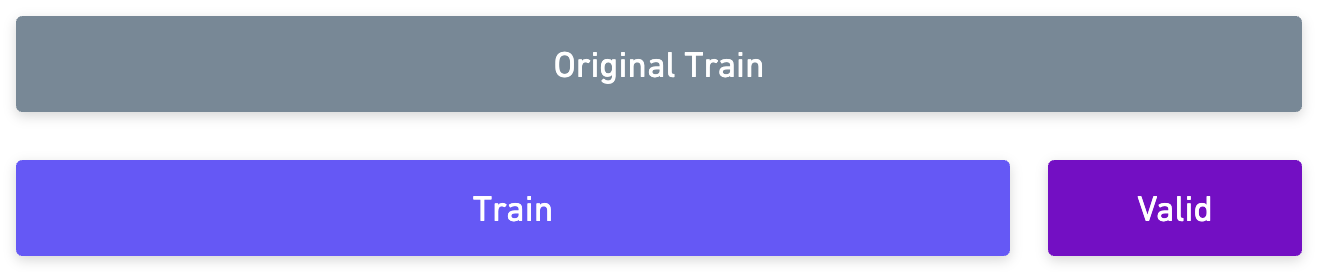

#### 👨‍💻 코드 : (2-1)


In [81]:
# 학습데이터를 학습/검증 데이터로 분리합니다.
# Sklearn의 Holdout을 이용해 랜덤으로 8:2로 분리합니다.

holdout_X_train, holdout_X_valid, holdout_Y_train, holdout_Y_valid = train_test_split(X_train, Y_train, test_size=0.2, shuffle=True) # default shuffle : True

display(f"Train Input : {holdout_X_train.shape}")
display(f"Train Target : {holdout_Y_train.shape}")
display(f"Valid Input : {holdout_X_valid.shape}")
display(f"Valid Target : {holdout_Y_valid.shape}")
display(f"Test Input : {X_test.shape}")
display(f"Valid Target : {Y_test.shape}")

'Train Input : (19130, 42)'

'Train Target : (19130,)'

'Valid Input : (4783, 42)'

'Valid Target : (4783,)'

'Test Input : (671, 42)'

'Valid Target : (671,)'

In [82]:
# LightGBM을 선언합니다.
# 학습은 총 1000번을 반복합니다.
# 데이터셋 분할에 따른 성능비교를 위해 별도의 Parameter 튜닝은 적용하지 않고 기본값을 사용합니다.

gbm = lgb.LGBMRegressor(n_estimators=1000)

In [83]:
# 학습을 진행합니다.
# 비교를 위해 %%time을 이용해 학습시간을 측정합니다.

gbm.fit(holdout_X_train, holdout_Y_train,                                                  # 학습 데이터를 입력합니다.
        eval_set=[(holdout_X_train, holdout_Y_train), (holdout_X_valid, holdout_Y_valid)], # 평가셋을 지정합니다.
        eval_metric ='rmse',                                                               # 평가과정에서 사용할 평가함수를 지정합니다.
        callbacks=[lgb.early_stopping(stopping_rounds=10),                                 # 10번의 성능향상이 없을 경우, 학습을 멈춥니다.
                   lgb.log_evaluation(period=10, show_stdv=True)]                          # 매 iteration마다 학습결과를 출력합니다.
)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000981 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7376
[LightGBM] [Info] Number of data points in the train set: 19130, number of used features: 41
[LightGBM] [Info] Start training from score 210620.800577
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 87711.2	training's l2: 7.69325e+09	valid_1's rmse: 85338.3	valid_1's l2: 7.28263e+09
[20]	training's rmse: 31328.4	training's l2: 9.81469e+08	valid_1's rmse: 30918	valid_1's l2: 9.55924e+08
[30]	training's rmse: 12612.5	training's l2: 1.59075e+08	valid_1's rmse: 13267.5	valid_1's l2: 1.76026e+08
[40]	training's rmse: 7384.49	training's l2: 5.45306e+07	valid_1's rmse: 8815.17	valid_1's l2: 7.77071e+07
[50]	training's rmse: 6208.63	training's l2: 3.85471e+07	valid_1's rmse: 8020.17	valid_1's l2: 6.43232e+07
[60]	training's rmse: 5825.59	training's l2: 3.39375e+07	va

,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.1
,n_estimators,1000
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [84]:
# 학습한 모델을 저장합니다.

joblib.dump(gbm, 'holdout_gbm.pkl')

['holdout_gbm.pkl']

In [85]:
# 저장한 모델을 불러옵니다.

gbm_trained = joblib.load('holdout_gbm.pkl')

In [86]:
# 불러온 모델을 통해 추론을 진행합니다.
# 이후, Test set에 대한 rmse를 측정합니다.

predicts = gbm_trained.predict(X_test)
RMSE = mean_squared_error(Y_test, predicts)**0.5
print(f"Test rmse : {RMSE}")

Test rmse : 11248.628513318128


- Holdout 학습의 최종결과는 아래와 같습니다.
  - Training Time : 29.9s
  - Train RMSE : 2097.48
  - Valid RMSE : 3015.71
  - Test RMSE : 3487.40

- Valid RMSE와 Test RMSE의 차이가 크게 나는 모습을 확인할 수 있습니다.
- Random하게 Train/valid의 Split을 진행했기에 Test셋에 대해서는 적합하지 않은 Valid셋이 구성되었다는 점을 알 수 있습니다.

#### 📚 자료
- [train_test_split - Scikit-Learn 공식문서](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)

### 2-2 K-Fold


#### 📝 설명 : (2-2)

- K번의 Holdout으로 데이터를 분리하는 방법입니다.
- K-1개를 학습 세트로, 1개를 검증 세트로 사용하며 동일한 Fold가 없도록 해야합니다.
- 최적의 학습,검증 Fold셋을 찾아내거나 모델들의 결과를 앙상블해서 사용합니다

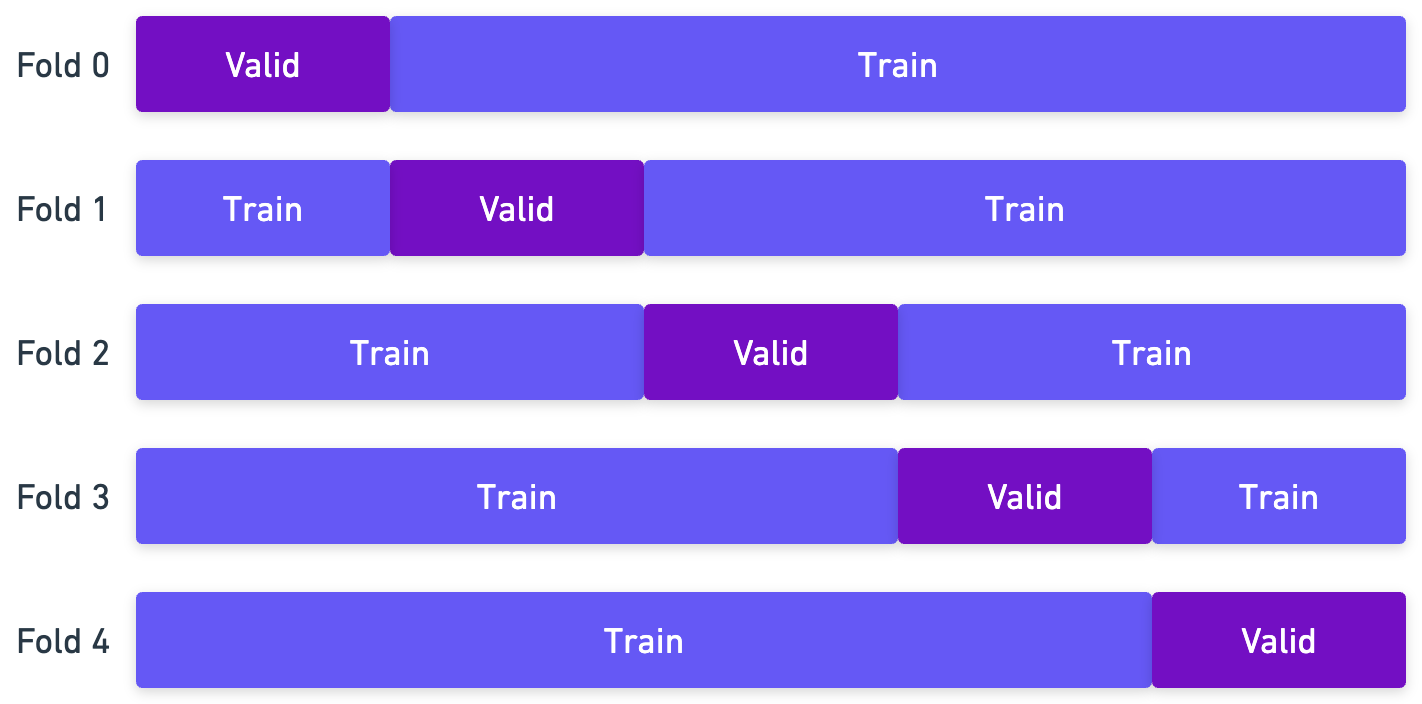


#### 👨‍💻 코드 : (2-2)

In [87]:
# 분할된 데이터를 fold별로 시각화하기 위한 함수를 구성합니다.
# Scikit-learn에서 https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html 사용한 코드를 가져와서 사용하겠습니다.
cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm

def plot_cv_indices(x, y, cv, ax, split_strategy='KFold', group=None, lw=10):
    """Create a sample plot for indices of a cross-validation object."""

    for ii, (tr, tt) in enumerate(cv.split(X=x, y=y, groups=group)):
        # Fill in indices with the training/test groups
        print(f"Fold {ii} :")
        print(f"  Train : index={tr[:5]}...")
        print(f"  Valid : index={tt[:5]}...")
        indices = np.array([np.nan] * len(x))
        indices[tt] = 1
        indices[tr] = 0
        # Visualize the results
        ax.scatter(
            range(len(indices)),
            [ii + 0.5] * len(indices),
            c=indices,
            marker="_",
            lw=lw,
            cmap=cmap_cv,
            vmin=-0.2,
            vmax=0.2,
        )

    # Formatting
    yticklabels = list(range(5))

    ax.set(
        yticks=np.arange(len(yticklabels)) + 0.5,
        yticklabels=yticklabels,
        xlabel="Sample index",
        ylabel="CV iteration",
        ylim=[len(yticklabels) + 0.2, -0.2],
        xlim=[0, len(x)],
    )
    ax.set_title(split_strategy, fontsize=15)
    return ax

In [88]:
# Kfold 함수를 선언합니다.
kf = KFold(n_splits=5)

Fold 0 :
  Train : index=[4783 4784 4785 4786 4787]...
  Valid : index=[0 1 2 3 4]...
Fold 1 :
  Train : index=[0 1 2 3 4]...
  Valid : index=[4783 4784 4785 4786 4787]...
Fold 2 :
  Train : index=[0 1 2 3 4]...
  Valid : index=[9566 9567 9568 9569 9570]...
Fold 3 :
  Train : index=[0 1 2 3 4]...
  Valid : index=[14349 14350 14351 14352 14353]...
Fold 4 :
  Train : index=[0 1 2 3 4]...
  Valid : index=[19131 19132 19133 19134 19135]...


<Axes: title={'center': 'K-Fold'}, xlabel='Sample index', ylabel='CV iteration'>

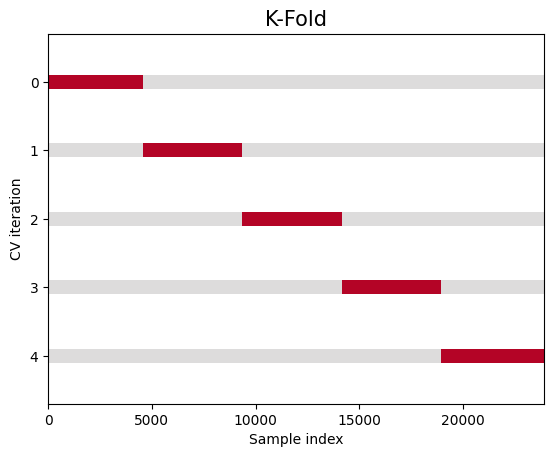

In [89]:
# kfold를 시각화합니다.
fig, ax = plt.subplots()
plot_cv_indices(x=X_train,
                y=Y_train,
                cv=kf,
                ax=ax,
                split_strategy='K-Fold')

In [90]:
# 학습 데이터를 Kfold로 나눕니다.
train_folds = kf.split(X_train, Y_train)
display(train_folds)

<generator object _BaseKFold.split at 0x11c2bd7a0>

- Kfold적용 시, 결과는 generator object로 반환됩니다.
- python generator는 iterator를 생성해주는 함수입니다.
- 즉, loop를 통해 불러올때 값을 확인할 수 있습니다.

In [91]:
# 학습을 진행합니다.
fold_save_files = []

for fold_idx, (train_idx, valid_idx) in enumerate(train_folds):
    print(f"--------{fold_idx}번째 fold의 학습을 시작합니다.--------")

    # index를 통해 fold의 학습세트를 가져옵니다.
    X_train_fold = X_train.iloc[train_idx, :]
    Y_train_fold = Y_train[train_idx]

    # index를 통해 fold의 평가세트를 가져옵니다.
    X_valid_fold = X_train.iloc[valid_idx, :]
    Y_valid_fold = Y_train[valid_idx]

    # fold의 데이터로 학습을 진행합니다.
    gbm = lgb.LGBMRegressor(n_estimators=1000)
    gbm.fit(X_train_fold, Y_train_fold,                                               # 학습 데이터를 입력합니다.
        eval_set=[(X_train_fold, Y_train_fold), (X_valid_fold, Y_valid_fold)], # 평가셋을 지정합니다.
        eval_metric ='rmse',                                                               # 평가과정에서 사용할 평가함수를 지정합니다.
        callbacks=[lgb.early_stopping(stopping_rounds=10),                                  # 10번의 성능향상이 없을 경우, 학습을 멈춥니다.
                   lgb.log_evaluation(period=10, show_stdv=True)]                           # 매 iteration마다 학습결과를 출력합니다.
    )

    # 각 fold별 학습한 모델을 저장합니다.
    file_name = f"kfold{fold_idx}_gbm.pkl"
    joblib.dump(gbm, file_name)
    print(f"--------{fold_idx}번째 fold는 {file_name}에 저장되었습니다.--------\n\n")
    fold_save_files.append(file_name)


--------0번째 fold의 학습을 시작합니다.--------
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001047 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7375
[LightGBM] [Info] Number of data points in the train set: 19130, number of used features: 41
[LightGBM] [Info] Start training from score 213637.534477
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 88236.2	training's l2: 7.78563e+09	valid_1's rmse: 82426.4	valid_1's l2: 6.7941e+09
[20]	training's rmse: 31448.3	training's l2: 9.88993e+08	valid_1's rmse: 29243.7	valid_1's l2: 8.55192e+08
[30]	training's rmse: 12510.5	training's l2: 1.56512e+08	valid_1's rmse: 13022.1	valid_1's l2: 1.69576e+08
[40]	training's rmse: 7146.99	training's l2: 5.10795e+07	valid_1's rmse: 10143.7	valid_1's l2: 1.02894e+08
[50]	training's rmse: 5929.17	training's l2: 3.51551e+07	valid_1's rmse: 10142	valid_1's l2: 1.0286e+08
Early stopping, best ite

In [92]:
# 저장한 학습모델들을 불러와, Testset에 대한 추론을 진행합니다.
# 각 fold의 예측결과를 평균을 취하는 방식으로 진행합니다.
total_predicts = np.zeros(len(X_test))

for file_name in fold_save_files:
    gbm_trained = joblib.load(file_name)
    fold_predicts = gbm_trained.predict(X_test)

    # 각 fold의 rmse를 측정합니다.
    RMSE = mean_squared_error(Y_test, fold_predicts)**0.5
    display(f"{file_name} - Test rmse : {RMSE}")

    total_predicts += fold_predicts / len(fold_save_files)

RMSE = mean_squared_error(Y_test, total_predicts)**0.5
display(f"최종 Test rmse : {RMSE}")

'kfold0_gbm.pkl - Test rmse : 12179.050787813521'

'kfold1_gbm.pkl - Test rmse : 11952.298693912015'

'kfold2_gbm.pkl - Test rmse : 12679.546083386178'

'kfold3_gbm.pkl - Test rmse : 12109.717247341698'

'kfold4_gbm.pkl - Test rmse : 14116.202282344932'

'최종 Test rmse : 12008.060250106118'

In [93]:
# 위 학습 로그에서 검증세트를 기준으로 rmse가 가장 낮은 3개의 모델을 선택후 추론을 진행합니다.

top_3_files = ["kfold1_gbm.pkl", "kfold3_gbm.pkl", "kfold4_gbm.pkl"]
total_predicts = np.zeros(len(X_test))

for file_name in top_3_files:
    gbm_trained = joblib.load(file_name)
    fold_predicts = gbm_trained.predict(X_test)

    # 각 fold의 rmse를 측정합니다.
    RMSE = mean_squared_error(Y_test, fold_predicts)**0.5
    display(f"{file_name} - Test rmse : {RMSE}")

    total_predicts += fold_predicts / len(top_3_files)

RMSE = mean_squared_error(Y_test, total_predicts)**0.5
display(f"최종 Test rmse : {RMSE}")

'kfold1_gbm.pkl - Test rmse : 11952.298693912015'

'kfold3_gbm.pkl - Test rmse : 12109.717247341698'

'kfold4_gbm.pkl - Test rmse : 14116.202282344932'

'최종 Test rmse : 12273.727175336291'

- K-Fold적용 시, 모든 Fold를 사용하는 것 보다 Valid RMSE 기준으로 Top3 Fold를 사용하는 것이 더 좋은 모습입니다.

- Kfold 학습의 최종결과는 아래와 같습니다.
  - Training Time : 40.5s
  - Train RMSE : fold마다 다름
  - Valid RMSE : fold마다 다름
  - Test RMSE(ALL) : 5290.11
  - Test RMSE(Top3) : 3243.60
  - Test RMSE(Top1) : 3447.76

- 현재까지 분할 별 Test RMSE 결과는 아래와 같습니다.
  - Holdout : 3487.40
  - KFold(Top3) : 3243.60

#### 📚 자료
- [KFold - Scikit-Learn 공식문서](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold)

### 2-3. Stratifiend K-Fold


#### 📝 설명 : (2-3)

- K개의 Fold를 구성하는 방법은 K-Fold와 동일하지만, Fold별 Y의 비율도 동일하게 하는 분할 방법입니다.
- 데이터의 양이 적거나 불균형이 심한 데이터에 대해 K-Fold적용 시 분포가 크게 달라지는 현상을 방지할 수 있습니다.


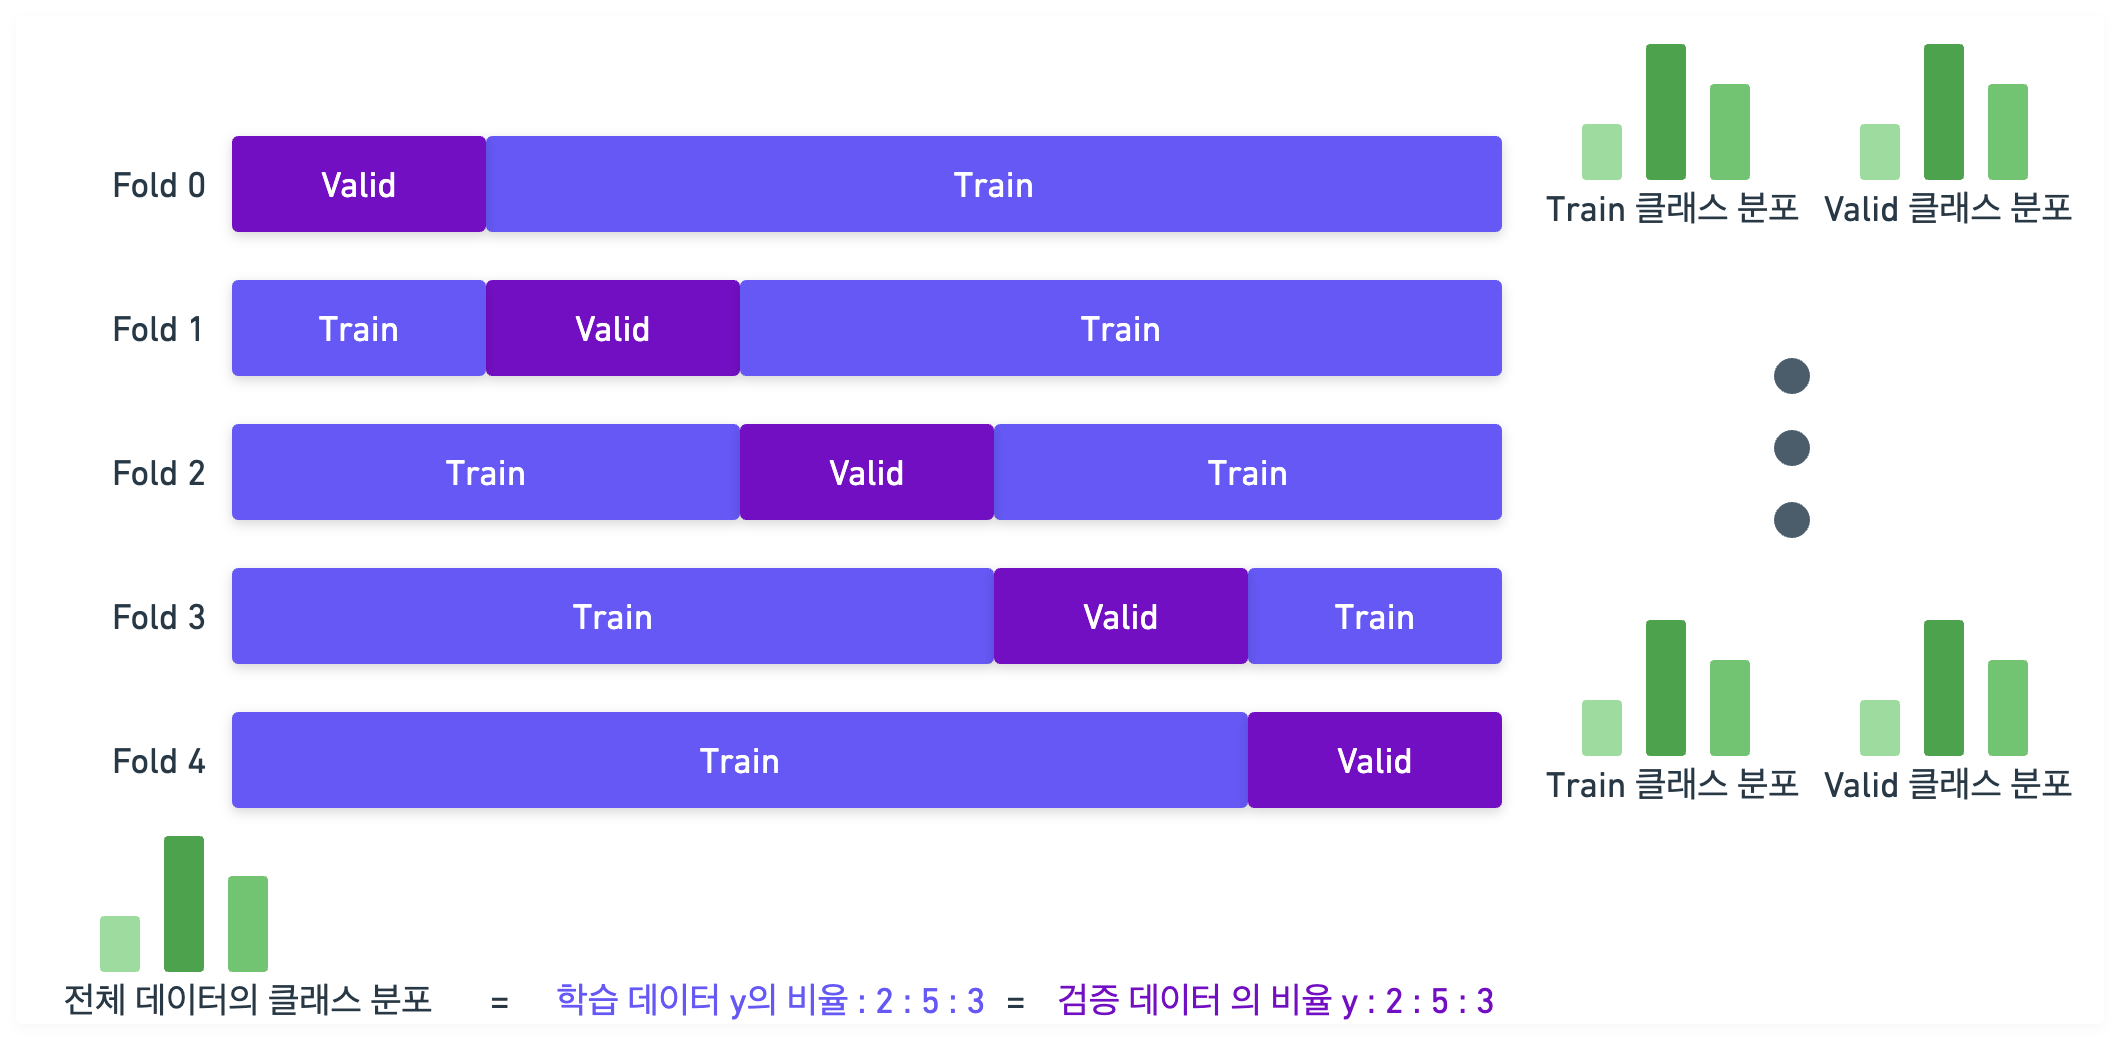

#### 👨‍💻 코드 : (2-3)


In [94]:
# Stratified Kfold 함수를 선언합니다.
kf = StratifiedKFold(n_splits=5)

In [95]:
# Target값을 기준으로 분포에 따라 1000등분합니다.
# Stratified KFold에서 각 구간을 기준으로 Y의 비율을 동일하게 가져가게 됩니다.
# 0, ... 9 = 0 / 10, ..., 19 = 1 / ..
cut_Y_train = pd.cut(Y_train,
                     1000, # 데이터를 최소 최대 구간으로 1000등분 합니다.
                     labels=False)

Fold 0 :
  Train : index=[ 57 165 265 302 342]...
  Valid : index=[0 1 2 3 4]...
Fold 1 :
  Train : index=[0 1 2 3 4]...
  Valid : index=[ 57 165 265 302 342]...
Fold 2 :
  Train : index=[0 1 2 3 4]...
  Valid : index=[375 468 671 749 779]...
Fold 3 :
  Train : index=[0 1 2 3 4]...
  Valid : index=[527 655 837 888 894]...
Fold 4 :
  Train : index=[0 1 2 3 4]...
  Valid : index=[ 444 1835 2049 2233 2321]...


<Axes: title={'center': 'Stratified K-Fold'}, xlabel='Sample index', ylabel='CV iteration'>

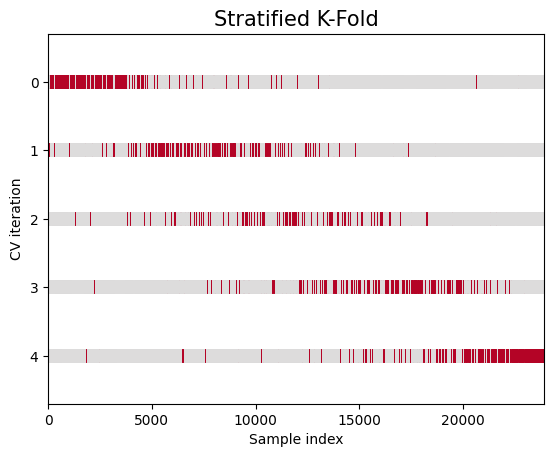

In [96]:
# Stratified Kfold를 시각화합니다.
# 앞의 kfold에서 정의한 시각화 함수를 사용합니다.
fig, ax = plt.subplots()
plot_cv_indices(x=X_train,
                y=cut_Y_train,
                cv=kf,
                ax=ax,
                split_strategy='Stratified K-Fold')

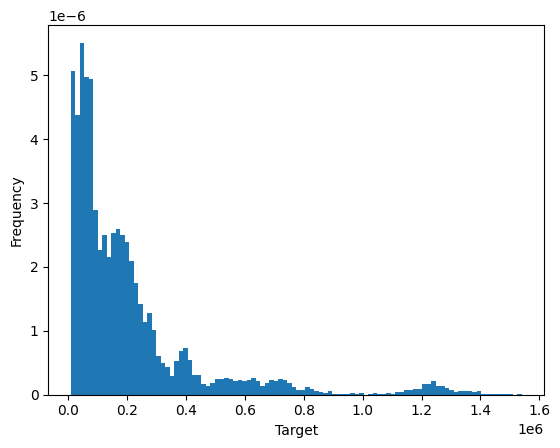

In [97]:
# 원래 Target값의 분포를 확인합니다.
plt.hist(Y_train, bins=100, density=True)
plt.xlabel('Target')
plt.ylabel('Frequency')
plt.show()

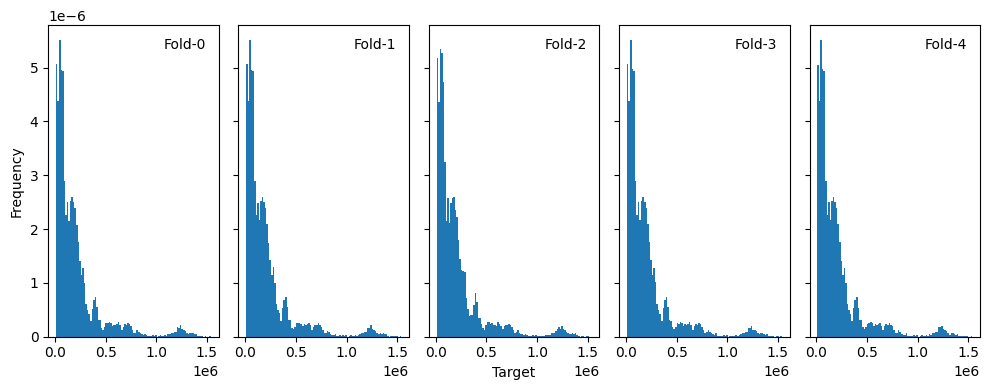

In [98]:
# 각 Fold별 분포를 시각화합니다.
fig, axs = plt.subplots(1, 5, sharex=True, sharey=True, figsize=(10,4)) # 5개의 plot을 만듭니다.
for fold_idx, (train_idx, valid_idx) in enumerate(kf.split(X_train, cut_Y_train)): # fold별로 iteration을 만듭니다.
    axs[fold_idx].hist(Y_train[train_idx], bins=100, density=True, label=f'Fold-{fold_idx}') # 각 fold에 해당하는 Target값을 가져옵니다.
    if fold_idx == 0:
        axs[fold_idx].set_ylabel('Frequency')
    if fold_idx == 2:
        axs[fold_idx].set_xlabel("Target")
    axs[fold_idx].legend(frameon=False, handlelength=0)
plt.tight_layout()
plt.show()

- 동일한 분포의 Target값을 가지는 것을 확인할 수 있습니다.

In [99]:
# 학습 데이터를 Stratified Kfold로 나눕니다.
train_folds = kf.split(X_train, cut_Y_train)
display(train_folds)

<generator object _BaseKFold.split at 0x11cb3b010>

In [103]:
# 학습을 진행합니다.
import time
start_time = time.time()

fold_save_files = []

for fold_idx, (train_idx, valid_idx) in enumerate(train_folds):
    print(f"--------{fold_idx}번째 fold의 학습을 시작합니다.--------")

    # index를 통해 fold의 학습세트를 가져옵니다.
    X_train_fold = X_train.iloc[train_idx, :]
    Y_train_fold = Y_train[train_idx]

    # index를 통해 fold의 평가세트를 가져옵니다.
    X_valid_fold = X_train.iloc[valid_idx, :]
    Y_valid_fold = Y_train[valid_idx]

    # fold의 데이터로 학습을 진행합니다.
    gbm = lgb.LGBMRegressor(n_estimators=1000)
    gbm.fit(
        X_train_fold,
        Y_train_fold,  # 학습 데이터를 입력합니다.
        eval_set=[(X_train_fold, Y_train_fold), (X_valid_fold, Y_valid_fold)],  # 평가셋을 지정합니다.
        eval_metric='rmse',  # 평가과정에서 사용할 평가함수를 지정합니다.
        callbacks=[
            lgb.early_stopping(stopping_rounds=10),  # 10번의 성능향상이 없을 경우, 학습을 멈춥니다.
            lgb.log_evaluation(period=10, show_stdv=True)  # 매 iteration마다 학습결과를 출력합니다.
        ]
    )

    # 각 fold별 학습한 모델을 저장합니다.
    file_name = f"Stratified_kfold{fold_idx}_gbm.pkl"
    joblib.dump(gbm, file_name)
    display(f"--------{fold_idx}번째 fold는 {file_name}에 저장되었습니다.--------\n\n")
    fold_save_files.append(file_name)

elapsed_time = time.time() - start_time
print(f"Training time: {elapsed_time:.1f}초")

--------0번째 fold의 학습을 시작합니다.--------
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001201 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7376
[LightGBM] [Info] Number of data points in the train set: 19130, number of used features: 41
[LightGBM] [Info] Start training from score 209933.841173
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 87520.2	training's l2: 7.65978e+09	valid_1's rmse: 85896.1	valid_1's l2: 7.37814e+09
[20]	training's rmse: 31203.1	training's l2: 9.73633e+08	valid_1's rmse: 31413.1	valid_1's l2: 9.86781e+08
[30]	training's rmse: 12413.9	training's l2: 1.54106e+08	valid_1's rmse: 14226.1	valid_1's l2: 2.02381e+08
[40]	training's rmse: 7103.51	training's l2: 5.04599e+07	valid_1's rmse: 10149.9	valid_1's l2: 1.03021e+08
[50]	training's rmse: 5914.47	training's l2: 3.4981e+07	valid_1's rmse: 9549.94	valid_1's l2: 9.12014e+07
[60]	training's rmse:

'--------0번째 fold는 Stratified_kfold0_gbm.pkl에 저장되었습니다.--------\n\n'

--------1번째 fold의 학습을 시작합니다.--------
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001157 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7376
[LightGBM] [Info] Number of data points in the train set: 19130, number of used features: 41
[LightGBM] [Info] Start training from score 209557.662589
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 87327.9	training's l2: 7.62616e+09	valid_1's rmse: 86236.2	valid_1's l2: 7.43668e+09
[20]	training's rmse: 31196.1	training's l2: 9.73195e+08	valid_1's rmse: 30638	valid_1's l2: 9.38687e+08
[30]	training's rmse: 12545.5	training's l2: 1.57389e+08	valid_1's rmse: 12568.9	valid_1's l2: 1.57977e+08
[40]	training's rmse: 7330.43	training's l2: 5.37352e+07	valid_1's rmse: 8119.93	valid_1's l2: 6.59332e+07
[50]	training's rmse: 6131.63	training's l2: 3.75969e+07	valid_1's rmse: 7489.17	valid_1's l2: 5.60877e+07
[60]	training's rmse: 

'--------1번째 fold는 Stratified_kfold1_gbm.pkl에 저장되었습니다.--------\n\n'

--------2번째 fold의 학습을 시작합니다.--------
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001249 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7376
[LightGBM] [Info] Number of data points in the train set: 19130, number of used features: 41
[LightGBM] [Info] Start training from score 209293.420046
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 86905.9	training's l2: 7.55264e+09	valid_1's rmse: 88399.9	valid_1's l2: 7.81454e+09
[20]	training's rmse: 31099	training's l2: 9.67148e+08	valid_1's rmse: 31620.6	valid_1's l2: 9.99859e+08
[30]	training's rmse: 12636.2	training's l2: 1.59674e+08	valid_1's rmse: 12928.2	valid_1's l2: 1.67138e+08
[40]	training's rmse: 7539.02	training's l2: 5.68368e+07	valid_1's rmse: 8029.87	valid_1's l2: 6.44788e+07
[50]	training's rmse: 6382.42	training's l2: 4.07353e+07	valid_1's rmse: 7232.56	valid_1's l2: 5.231e+07
[60]	training's rmse: 59

'--------2번째 fold는 Stratified_kfold2_gbm.pkl에 저장되었습니다.--------\n\n'

--------3번째 fold의 학습을 시작합니다.--------
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000886 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7376
[LightGBM] [Info] Number of data points in the train set: 19131, number of used features: 41
[LightGBM] [Info] Start training from score 209343.866302
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 87019.4	training's l2: 7.57238e+09	valid_1's rmse: 87752.7	valid_1's l2: 7.70054e+09
[20]	training's rmse: 31141.7	training's l2: 9.69804e+08	valid_1's rmse: 31115.7	valid_1's l2: 9.68187e+08
[30]	training's rmse: 12638.3	training's l2: 1.59726e+08	valid_1's rmse: 12429.2	valid_1's l2: 1.54485e+08
[40]	training's rmse: 7511.04	training's l2: 5.64158e+07	valid_1's rmse: 7655.73	valid_1's l2: 5.86102e+07
[50]	training's rmse: 6350.55	training's l2: 4.03294e+07	valid_

'--------3번째 fold는 Stratified_kfold3_gbm.pkl에 저장되었습니다.--------\n\n'

--------4번째 fold의 학습을 시작합니다.--------
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000504 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7376
[LightGBM] [Info] Number of data points in the train set: 19131, number of used features: 41
[LightGBM] [Info] Start training from score 209472.379388
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 87183	training's l2: 7.60088e+09	valid_1's rmse: 87444.5	valid_1's l2: 7.64654e+09
[20]	training's rmse: 31203	training's l2: 9.73625e+08	valid_1's rmse: 31350.5	valid_1's l2: 9.82851e+08
[30]	training's rmse: 12672.1	training's l2: 1.60583e+08	valid_1's rmse: 12781.1	valid_1's l2: 1.63356e+08
[40]	training's rmse: 7571.43	training's l2: 5.73266e+07	valid_1's rmse: 7837.81	valid_1's l2: 6.14312e+07
[50]	training's rmse: 6407.23	training's l2: 4.10526e+07	valid_1's 

'--------4번째 fold는 Stratified_kfold4_gbm.pkl에 저장되었습니다.--------\n\n'

Training time: 3.2초


In [ ]:
# 저장한 학습모델들을 불러와, Testset에 대한 추론을 진행합니다.
# 각 fold의 예측결과를 평균을 취하는 방식으로 진행합니다.
total_predicts = np.zeros(len(X_test))

for file_name in fold_save_files:
    gbm_trained = joblib.load(file_name)
    fold_predicts = gbm_trained.predict(X_test)

    # 각 fold의 rmse를 측정합니다.
    RMSE = mean_squared_error(Y_test, fold_predicts)**0.5
    display(f"{file_name} - Test rmse : {RMSE}")

    total_predicts += fold_predicts / len(fold_save_files)

RMSE = mean_squared_error(Y_test, total_predicts)**0.5
display(f"최종 Test rmse : {RMSE}")

In [104]:
# 위 학습 로그에서 검증세트를 기준으로 rmse가 가장 낮은 3개의 모델을 선택후 추론을 진행합니다.
# 실습하는 과정에서 가장 잘 나온 3개로 한번 테스트를 진행해보시기 바랍니다.
top_3_files = ["Stratified_kfold1_gbm.pkl", "Stratified_kfold2_gbm.pkl", "Stratified_kfold3_gbm.pkl"]
total_predicts = np.zeros(len(X_test))

for file_name in top_3_files:
    gbm_trained = joblib.load(file_name)
    fold_predicts = gbm_trained.predict(X_test)

    # 각 fold의 rmse를 측정합니다.
    RMSE = mean_squared_error(Y_test, fold_predicts)**0.5
    display(f"{file_name} - Test rmse : {RMSE}")

    total_predicts += fold_predicts / len(top_3_files)

RMSE = mean_squared_error(Y_test, total_predicts)**0.5
display(f"최종 Test rmse : {RMSE}")

'Stratified_kfold1_gbm.pkl - Test rmse : 12254.77996091253'

'Stratified_kfold2_gbm.pkl - Test rmse : 11590.084828463407'

'Stratified_kfold3_gbm.pkl - Test rmse : 12598.374206236565'

'최종 Test rmse : 11960.853821349445'

- StratifiedKfold 학습의 최종결과는 아래와 같습니다.
  - Training Time : 1분 41초
  - Train RMSE : fold마다 다름
  - Valid RMSE : fold마다 다름
  - Test RMSE(ALL) : 3292.13
  - Test RMSE(Top3) : 3357.02
  - Test RMSE(Top1) : 3237.07

- 현재까지 분할 별 Test RMSE 결과는 아래와 같습니다.
  - Holdout : 3487.40
  - KFold(Top3) : 3243.60
  - Stratified KFold(Top) : 3237.07

#### 📚 자료

- [KFold - Scikit-Learn 공식문서](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold)

### 2-4. Group K-Fold


#### 📝 설명 : (2-4)
- 특정 목적하에 사용되는 확장된 K-Fold 방법입니다.
- Train과 Valid에 같은 값이 들어가지 않도록 Group을 구성 후, Fold별로 Group을 분배합니다.
- 이번 실습에서는 group을 종목별과 산업군별로 각각 group kfold를 적용해봅니다.


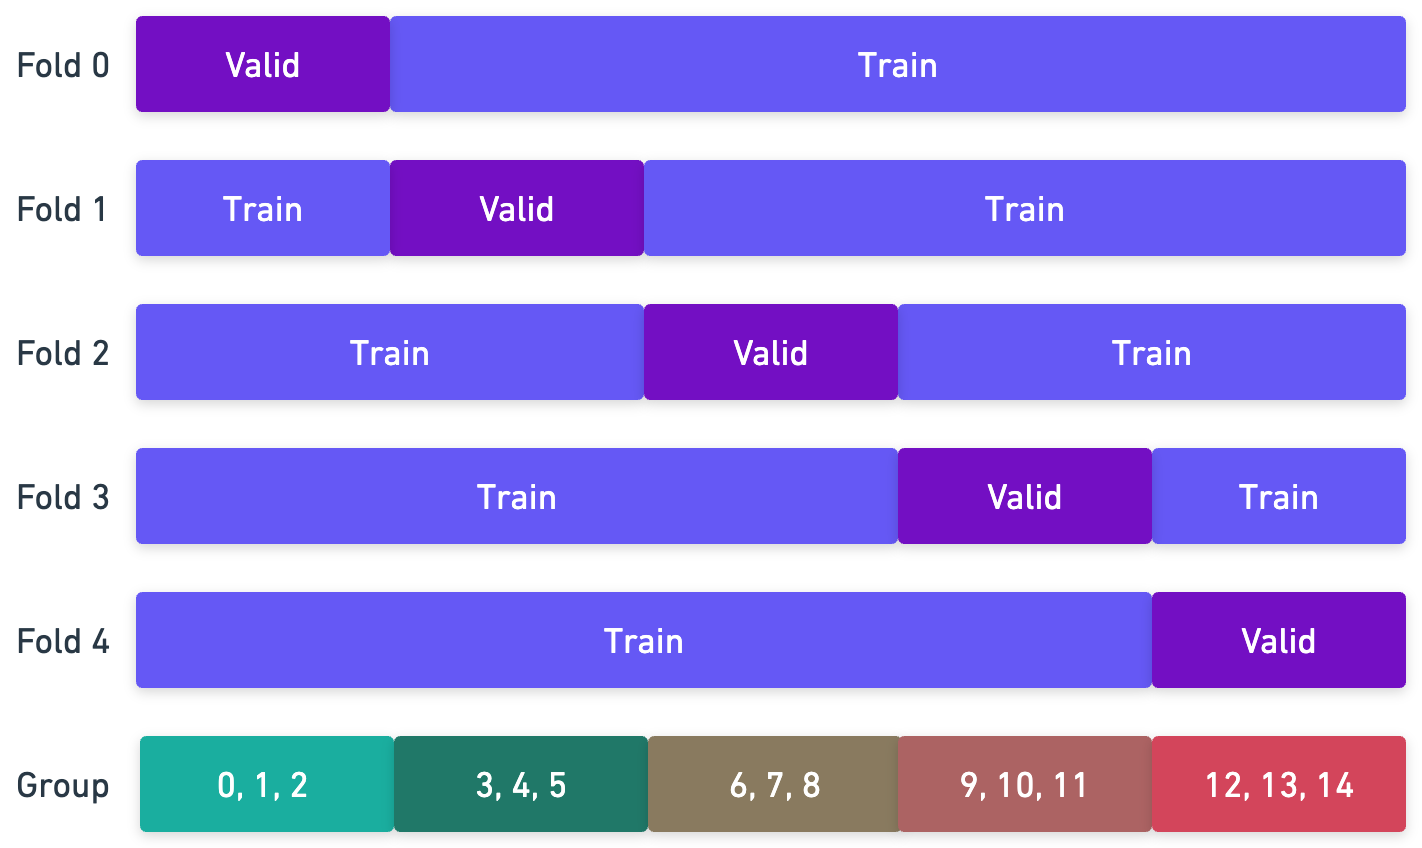

#### 👨‍💻 코드 : (2-4)


In [ ]:
# 종목(code)를 Group을 나누는 기준으로 사용합니다.
groups = list(X_train['LEncodedCode'].astype('int'))

In [ ]:
# GroupKfold 함수를 선언합니다.
kf = GroupKFold(n_splits=5)

In [ ]:
# GroupKfold를 시각화합니다.
fig, ax = plt.subplots()
plot_cv_indices(x=X_train.sort_values(by='LEncodedCode'),
                y=Y_train,
                cv=kf,
                group=groups,
                ax=ax,
                split_strategy='Code Group K-Fold')

In [ ]:
# 학습 데이터를 GroupKfold로 나눕니다.
train_folds = kf.split(X_train, Y_train, groups=groups)
display(train_folds)

- Kfold적용 시, 결과는 generator object로 반환됩니다.
- python generator는 iterator를 생성해주는 함수이다.
- 즉, loop를 통해 불러올때 값을 확인할 수 있습니다.

In [ ]:
# 학습을 진행합니다.
%%time
fold_save_files = []

for fold_idx, (train_idx, valid_idx) in enumerate(train_folds):
    display(f"--------{fold_idx}번째 fold의 학습을 시작합니다.--------")

    # index를 통해 fold의 학습세트를 가져옵니다.
    X_train_fold = X_train.iloc[train_idx, :]
    Y_train_fold = Y_train[train_idx]

    # index를 통해 fold의 평가세트를 가져옵니다.
    X_valid_fold = X_train.iloc[valid_idx, :]
    Y_valid_fold = Y_train[valid_idx]

    # fold의 데이터로 학습을 진행합니다.
    gbm = lgb.LGBMRegressor(n_estimators=1000)
    gbm.fit(X_train_fold, Y_train_fold,                                               # 학습 데이터를 입력합니다.
        eval_set=[(X_train_fold, Y_train_fold), (X_valid_fold, Y_valid_fold)], # 평가셋을 지정합니다.
        eval_metric ='rmse',                                                               # 평가과정에서 사용할 평가함수를 지정합니다.
        callbacks=[lgb.early_stopping(stopping_rounds=10),                                  # 10번의 성능향상이 없을 경우, 학습을 멈춥니다.
                   lgb.log_evaluation(period=10, show_stdv=True)]                           # 매 iteration마다 학습결과를 출력합니다.
    )

    # 각 fold별 학습한 모델을 저장합니다.
    file_name = f"groupd_kfold{fold_idx}_gbm.pkl"
    joblib.dump(gbm, file_name)
    display(f"--------{fold_idx}번째 fold는 {file_name}에 저장되었습니다.--------\n\n")
    fold_save_files.append(file_name)


In [ ]:
# 저장한 학습모델들을 불러와, Testset에 대한 추론을 진행합니다.
# 각 fold의 예측결과를 평균을 취하는 방식으로 진행합니다.
total_predicts = np.zeros(len(X_test))

for file_name in fold_save_files:
    gbm_trained = joblib.load(file_name)
    fold_predicts = gbm_trained.predict(X_test)

    # 각 fold의 rmse를 측정합니다.
    RMSE = mean_squared_error(Y_test, fold_predicts)**0.5
    display(f"{file_name} - Test rmse : {RMSE}")

    total_predicts += fold_predicts / len(fold_save_files)

RMSE = mean_squared_error(Y_test, total_predicts)**0.5
display(f"최종 Test rmse : {RMSE}")

In [ ]:
# 위 학습 로그에서 검증세트를 기준으로 rmse가 가장 낮은 3개의 모델을 선택후 추론을 진행합니다.
top_3_files = ["groupd_kfold0_gbm.pkl", "groupd_kfold2_gbm.pkl", "groupd_kfold4_gbm.pkl"]
total_predicts = np.zeros(len(X_test))

for file_name in top_3_files:
    gbm_trained = joblib.load(file_name)
    fold_predicts = gbm_trained.predict(X_test)

    # 각 fold의 rmse를 측정합니다.
    RMSE = mean_squared_error(Y_test, fold_predicts)**0.5
    display(f"{file_name} - Test rmse : {RMSE}")

    total_predicts += fold_predicts / len(top_3_files)

RMSE = mean_squared_error(Y_test, total_predicts)**0.5
display(f"최종 Test rmse : {RMSE}")

- 종목별 Group Kfold 학습의 최종결과는 아래와 같습니다.
  - Training Time : 50s
  - Train RMSE : fold마다 다름
  - Valid RMSE : fold마다 다름
  - Test RMSE(ALL) : 4912.87
  - Test RMSE(Top3) : 3442.06
  - Test RMSE(Top1) : 3637.26

- 현재까지 분할 별 Test RMSE 결과는 아래와 같습니다.
  - Holdout : 3487.40
  - KFold(Top3) : 3243.60
  - Stratified KFold(Top) : 3237.07
  - 종목별 Group KFold(Top3) : 3442.06

- 위 예시는 종목별 구분이지만, IT와 같이 산업군으로 group을 나누어 적용해 볼 수 있습니다.

#### 👨‍💻 코드 : (2-4)

In [ ]:
# 산업군(Industry)를 Group을 나누는 기준으로 사용합니다.
groups = list(X_train['LEncodedIndustry'].astype('int'))

In [ ]:
# GroupKfold 함수를 선언합니다.
kf = GroupKFold(n_splits=5)

In [ ]:
# GroupKfold를 시각화합니다.
fig, ax = plt.subplots()
plot_cv_indices(x=X_train.sort_values(by='LEncodedIndustry'),
                y=Y_train,
                cv=kf,
                group=groups,
                ax=ax,
                split_strategy='Industry Group K-Fold')

In [ ]:
# 학습 데이터를 GroupKfold로 나눕니다.
train_folds = kf.split(X_train, Y_train, groups=groups)
display(train_folds)

- Kfold적용 시, 결과는 generator object로 반환됩니다.
- python generator는 iterator를 생성해주는 함수이다.
- 즉, loop를 통해 불러올때 값을 확인할 수 있습니다.

In [ ]:
# 학습을 진행합니다.
%%time
fold_save_files = []

for fold_idx, (train_idx, valid_idx) in enumerate(train_folds):
    display(f"--------{fold_idx}번째 fold의 학습을 시작합니다.--------")

    # index를 통해 fold의 학습세트를 가져옵니다.
    X_train_fold = X_train.iloc[train_idx, :]
    Y_train_fold = Y_train[train_idx]

    # index를 통해 fold의 평가세트를 가져옵니다.
    X_valid_fold = X_train.iloc[valid_idx, :]
    Y_valid_fold = Y_train[valid_idx]

    # fold의 데이터로 학습을 진행합니다.
    gbm = lgb.LGBMRegressor(n_estimators=1000)
    gbm.fit(X_train_fold, Y_train_fold,                                               # 학습 데이터를 입력합니다.
        eval_set=[(X_train_fold, Y_train_fold), (X_valid_fold, Y_valid_fold)], # 평가셋을 지정합니다.
        eval_metric ='rmse',                                                               # 평가과정에서 사용할 평가함수를 지정합니다.
        callbacks=[lgb.early_stopping(stopping_rounds=10),                                  # 10번의 성능향상이 없을 경우, 학습을 멈춥니다.
                   lgb.log_evaluation(period=10, show_stdv=True)]                           # 매 iteration마다 학습결과를 출력합니다.
    )

    # 각 fold별 학습한 모델을 저장합니다.
    file_name = f"industry_groupd_kfold{fold_idx}_gbm.pkl"
    joblib.dump(gbm, file_name)
    display(f"--------{fold_idx}번째 fold는 {file_name}에 저장되었습니다.--------\n\n")
    fold_save_files.append(file_name)


In [ ]:
# 저장한 학습모델들을 불러와, Testset에 대한 추론을 진행합니다.
# 각 fold의 예측결과를 평균을 취하는 방식으로 진행합니다.
total_predicts = np.zeros(len(X_test))

for file_name in fold_save_files:
    gbm_trained = joblib.load(file_name)
    fold_predicts = gbm_trained.predict(X_test)

    # 각 fold의 rmse를 측정합니다.
    RMSE = mean_squared_error(Y_test, fold_predicts)**0.5
    display(f"{file_name} - Test rmse : {RMSE}")

    total_predicts += fold_predicts / len(fold_save_files)

RMSE = mean_squared_error(Y_test, total_predicts)**0.5
display(f"최종 Test rmse : {RMSE}")

In [ ]:
# 위 학습 로그에서 검증세트를 기준으로 rmse가 가장 낮은 3개의 모델을 선택후 추론을 진행합니다.
top_3_files = ["industry_groupd_kfold0_gbm.pkl", "industry_groupd_kfold1_gbm.pkl", "industry_groupd_kfold2_gbm.pkl"]
total_predicts = np.zeros(len(X_test))

for file_name in top_3_files:
    gbm_trained = joblib.load(file_name)
    fold_predicts = gbm_trained.predict(X_test)

    # 각 fold의 rmse를 측정합니다.
    RMSE = mean_squared_error(Y_test, fold_predicts)**0.5
    display(f"{file_name} - Test rmse : {RMSE}")

    total_predicts += fold_predicts / len(top_3_files)

RMSE = mean_squared_error(Y_test, total_predicts)**0.5
display(f"최종 Test rmse : {RMSE}")

- 산업군별 Group Kfold 학습의 최종결과는 아래와 같습니다.
  - Training Time : 29.9s
  - Train RMSE : fold마다 다름
  - Valid RMSE : fold마다 다름
  - Test RMSE(ALL) : 3529.99
  - Test RMSE(Top3) : 3288.77
  - Test RMSE(Top1) : 3347.86

- 현재까지 분할 별 Test RMSE 결과는 아래와 같습니다.
  - Holdout : 3487.40
  - KFold(Top3) : 3243.60
  - Stratified KFold(Top) : 3237.07
  - 종목별 Group KFold(Top3) : 3442.06
  - 산업군별 Group KFold(Top3) : 3288.77

#### 📚 자료

- [GroupKFold - Scikit-Learn 공식문서](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupKFold.html#sklearn.model_selection.GroupKFold)

### 2-5. Time-Series Split


#### 📝 설명 : (2-5)

- 시계열 데이터에 사용되는 확장된 K-Fold 방법입니다.
- 과거의 데이터를 통해 미래를 예측하는 데이터의 구조를 유지한 채 Fold를 나누는 방법입니다.

<br>
<img src="https://velog.velcdn.com/images/dlehd1989/post/eedadef4-631b-4684-ad65-899db85192d9/image.png">
<br>


#### 👨‍💻 코드 : (2-5)


In [ ]:
# TimeSeriesSplit 함수를 선언합니다.
kf = TimeSeriesSplit(n_splits=5)

In [ ]:
# TimeSeriesSplit를 시각화합니다.
fig, ax = plt.subplots()
plot_cv_indices(x=X_train,
                y=Y_train,
                cv=kf,
                ax=ax,
                split_strategy='Time-Series K-Fold')

In [ ]:
# 학습 데이터를 TimeSeriesSplit로 나눕니다.
train_folds = kf.split(X_train, Y_train)
display(train_folds)

In [ ]:
# 학습을 진행합니다.
%%time
fold_save_files = []

for fold_idx, (train_idx, valid_idx) in enumerate(train_folds):
    display(f"--------{fold_idx}번째 fold의 학습을 시작합니다.--------")

    # index를 통해 fold의 학습세트를 가져옵니다.
    X_train_fold = X_train.iloc[train_idx, :]
    Y_train_fold = Y_train[train_idx]

    # index를 통해 fold의 평가세트를 가져옵니다.
    X_valid_fold = X_train.iloc[valid_idx, :]
    Y_valid_fold = Y_train[valid_idx]

    # fold의 데이터로 학습을 진행합니다.
    gbm = lgb.LGBMRegressor(n_estimators=1000)
    gbm.fit(X_train_fold, Y_train_fold,                                               # 학습 데이터를 입력합니다.
        eval_set=[(X_train_fold, Y_train_fold), (X_valid_fold, Y_valid_fold)], # 평가셋을 지정합니다.
        eval_metric ='rmse',                                                               # 평가과정에서 사용할 평가함수를 지정합니다.
        callbacks=[lgb.early_stopping(stopping_rounds=10),                                  # 10번의 성능향상이 없을 경우, 학습을 멈춥니다.
                   lgb.log_evaluation(period=10, show_stdv=True)]                           # 매 iteration마다 학습결과를 출력합니다.
    )

    # 각 fold별 학습한 모델을 저장합니다.
    file_name = f"timeseries_fold{fold_idx}_gbm.pkl"
    joblib.dump(gbm, file_name)
    display(f"--------{fold_idx}번째 fold는 {file_name}에 저장되었습니다.--------\n\n")
    fold_save_files.append(file_name)


In [ ]:
# 저장한 학습모델들을 불러와, Testset에 대한 추론을 진행합니다.
# 각 fold의 예측결과를 평균을 취하는 방식으로 진행합니다.
total_predicts = np.zeros(len(X_test))

for file_name in fold_save_files:
    gbm_trained = joblib.load(file_name)
    fold_predicts = gbm_trained.predict(X_test)

    # 각 fold의 rmse를 측정합니다.
    RMSE = mean_squared_error(Y_test, fold_predicts)**0.5
    display(f"{file_name} - Test rmse : {RMSE}")

    total_predicts += fold_predicts / len(fold_save_files)

RMSE = mean_squared_error(Y_test, total_predicts)**0.5
display(f"최종 Test rmse : {RMSE}")

In [ ]:
# 위 학습 로그에서 검증세트를 기준으로 rmse가 가장 낮은 3개의 모델을 선택후 추론을 진행합니다.
top_3_files = ["timeseries_fold0_gbm.pkl", "timeseries_fold2_gbm.pkl", "timeseries_fold4_gbm.pkl"]
total_predicts = np.zeros(len(X_test))

for file_name in top_3_files:
    gbm_trained = joblib.load(file_name)
    fold_predicts = gbm_trained.predict(X_test)

    # 각 fold의 rmse를 측정합니다.
    RMSE = mean_squared_error(Y_test, fold_predicts)**0.5
    display(f"{file_name} - Test rmse : {RMSE}")

    total_predicts += fold_predicts / len(top_3_files)

RMSE = mean_squared_error(Y_test, total_predicts)**0.5
display(f"최종 Test rmse : {RMSE}")

- Time-Series Split 학습의 최종결과는 아래와 같습니다.
  - Training Time : 33.2 s
  - Train RMSE : fold마다 다름
  - Valid RMSE : fold마다 다름
  - Test RMSE(ALL) : 3295.32
  - Test RMSE(Top3) : 3211.75
  - Test RMSE(Top1) : 3385.43

- 현재까지 분할 별 Test RMSE 결과는 아래와 같습니다.
  - Holdout : 3487.40
  - KFold(Top3) : 3243.60
  - Stratified KFold(Top) : 3237.07
  - 종목별 Group KFold(Top3) : 3442.06
  - 산업군별 Group KFold(Top3) : 3288.77
  - TimeSeries KFold(Top3) : 3211.75

❗ **최종적으로 아래와 같은 결과를 얻을 수 있습니다.**


| Method                 | Training Time | Test RMSE (ALL) | Test RMSE (Top3) | Test RMSE (Top1) |
|------------------------|---------------|-----------------|------------------|------------------|
| Holdout                | 29.9s         | 3487.40         | -                | -                |
| K-Fold                 | 40.5s         | 5290.11         | 3243.60          | 3447.76          |
| StratifiedKfold        | 101s      | 3292.13         | 3357.02          | 3237.07          |
| 종목별 Group Kfold      | 50s           | 4912.87         | 3442.06          | 3637.26          |
| 산업군별 Group Kfold     | 44.7s         | 3529.99         | 3288.77          | 3347.86          |
| Time-Series Split      | 33.2s         | 3295.32         | 3211.75          | 3385.43          |


- 주가데이터의 형태와 비슷한 Time-Series Split이 가장 좋은 성능을 보였습니다.
- 따라서, 주어진 데이터를 분석하고 도메인에 맞는 분할을 적용하는 것이 중요합니다.

#### 📚 자료

- [TimeSeriesSplit - Scikit-Learn 공식문서](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html#sklearn.model_selection.TimeSeriesSplit)

### Appendix. Time-Series Split (Split by Time index)


#### 📝 설명 : Appendix

- 위 시계열 분할 과정에 대해, 데이터를 "TimeSeries 정렬"로 분할하여 학습을 진행하는 과정입니다.

<br>
<img src="https://velog.velcdn.com/images/dlehd1989/post/eedadef4-631b-4684-ad65-899db85192d9/image.png">
<br>


#### 👨‍💻 코드 : Appendix


In [ ]:
# TimeSeriesSplit 함수를 선언합니다.
kf = TimeSeriesSplit(n_splits=5)

In [ ]:
# 시간순 정렬을 위해 이전에 저장해두었던 시간정보를 붙입니다.
X_train['Date'] = date_list

X_train = X_train.sort_values(by='Date') # 시간순으로 정렬합니다.
Y_train = Y_train.reindex(X_train.index) # 정렬된 X_train의 인덱스에 맞추어 Y_train도 정렬해줍니다.

X_train = X_train.reset_index(drop=True) # 인덱스를 재정렬 해줍니다.
Y_train = Y_train.reset_index(drop=True)

del X_train['Date'] # 시간에 대한 정보를 지웁니다.

In [ ]:
# TimeSeriesSplit를 시각화합니다.
fig, ax = plt.subplots()
plot_cv_indices(x=X_train,
                y=Y_train,
                cv=kf,
                ax=ax,
                split_strategy='Time-Series K-Fold')

In [ ]:
# 학습 데이터를 TimeSeriesSplit로 나눕니다.
train_folds = kf.split(X_train, Y_train)
display(train_folds)

In [ ]:
# 학습을 진행합니다.
%%time
fold_save_files = []

for fold_idx, (train_idx, valid_idx) in enumerate(train_folds):
    display(f"--------{fold_idx}번째 fold의 학습을 시작합니다.--------")

    # index를 통해 fold의 학습세트를 가져옵니다.
    X_train_fold = X_train.iloc[train_idx, :]
    Y_train_fold = Y_train[train_idx]

    # index를 통해 fold의 평가세트를 가져옵니다.
    X_valid_fold = X_train.iloc[valid_idx, :]
    Y_valid_fold = Y_train[valid_idx]

    # fold의 데이터로 학습을 진행합니다.
    gbm = lgb.LGBMRegressor(n_estimators=1000)
    gbm.fit(X_train_fold, Y_train_fold,                                               # 학습 데이터를 입력합니다.
        eval_set=[(X_train_fold, Y_train_fold), (X_valid_fold, Y_valid_fold)], # 평가셋을 지정합니다.
        eval_metric ='rmse',                                                               # 평가과정에서 사용할 평가함수를 지정합니다.
        callbacks=[lgb.early_stopping(stopping_rounds=10),                                  # 10번의 성능향상이 없을 경우, 학습을 멈춥니다.
                   lgb.log_evaluation(period=10, show_stdv=True)]                           # 매 iteration마다 학습결과를 출력합니다.
    )

    # 각 fold별 학습한 모델을 저장합니다.
    file_name = f"timeseries_fold{fold_idx}_gbm.pkl"
    joblib.dump(gbm, file_name)
    display(f"--------{fold_idx}번째 fold는 {file_name}에 저장되었습니다.--------\n\n")
    fold_save_files.append(file_name)


In [ ]:
# 저장한 학습모델들을 불러와, Testset에 대한 추론을 진행합니다.
# 각 fold의 예측결과를 평균을 취하는 방식으로 진행합니다.
total_predicts = np.zeros(len(X_test))

for file_name in fold_save_files:
    gbm_trained = joblib.load(file_name)
    fold_predicts = gbm_trained.predict(X_test)

    # 각 fold의 rmse를 측정합니다.
    RMSE = mean_squared_error(Y_test, fold_predicts)**0.5
    display(f"{file_name} - Test rmse : {RMSE}")

    total_predicts += fold_predicts / len(fold_save_files)

RMSE = mean_squared_error(Y_test, total_predicts)**0.5
display(f"최종 Test rmse : {RMSE}")

In [ ]:
# 위 학습 로그에서 검증세트를 기준으로 rmse가 가장 낮은 3개의 모델을 선택후 추론을 진행합니다.
top_3_files = ["timeseries_fold2_gbm.pkl", "timeseries_fold3_gbm.pkl", "timeseries_fold4_gbm.pkl"]
total_predicts = np.zeros(len(X_test))

for file_name in top_3_files:
    gbm_trained = joblib.load(file_name)
    fold_predicts = gbm_trained.predict(X_test)

    # 각 fold의 rmse를 측정합니다.
    RMSE = mean_squared_error(Y_test, fold_predicts)**0.5
    display(f"{file_name} - Test rmse : {RMSE}")

    total_predicts += fold_predicts / len(top_3_files)

RMSE = mean_squared_error(Y_test, total_predicts)**0.5
display(f"최종 Test rmse : {RMSE}")

# - 시간순으로 정렬된 Time-Series Split 학습의 최종결과는 아래와 같습니다.
  - Training Time : 33.2 s
  - Train RMSE : fold마다 다름
  - Valid RMSE : fold마다 다름
  - Test RMSE(ALL) : 8570.08
  - Test RMSE(Top3) : 3578.11
  - Test RMSE(Top1) : 3442.75

- 현재까지 분할 별 Test RMSE 결과는 아래와 같습니다.
  - Holdout : 3487.40
  - KFold(Top3) : 3243.60
  - Stratified KFold(Top) : 3237.07
  - 종목별 Group KFold(Top3) : 3442.06
  - 산업군별 Group KFold(Top3) : 3288.77
  - TimeSeries KFold(Top3) : 3211.75
  - 시간정렬 TimeSeries KFold(Top1) : 3442.75

❗ **최종적으로 아래와 같은 결과를 얻을 수 있습니다.**


| Method                 | Training Time | Test RMSE (ALL) | Test RMSE (Top3) | Test RMSE (Top1) |
|------------------------|---------------|-----------------|------------------|------------------|
| Holdout                | 29.9s         | 3487.40         | -                | -                |
| K-Fold                 | 40.5s         | 5290.11         | 3243.60          | 3447.76          |
| StratifiedKfold        | 101s      | 3292.13         | 3357.02          | 3237.07          |
| 종목별 Group Kfold      | 50s           | 4912.87         | 3442.06          | 3637.26          |
| 산업군별 Group Kfold     | 44.7s         | 3529.99         | 3288.77          | 3347.86          |
| Time-Series Split      | 33.2s         | 3295.32         | 3211.75          | 3385.43          |
| 시간정렬 Time-Series Split | 33.2s     | 8570.08         | 3578.11          | 3442.75       |


#### 📚 자료

- [TimeSeriesSplit - Scikit-Learn 공식문서](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html#sklearn.model_selection.TimeSeriesSplit)

#Reference

- [LightGBM](https://lightgbm.readthedocs.io/en/latest/index.html)
- [Scikit-Learn](https://scikit-learn.org/stable/index.html)